In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go 
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import plotly.io as pio
pio.templates.default = "plotly_dark"
from sklearn import preprocessing

In [56]:
import xgboost as xgb 
from catboost import CatBoostRegressor 

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold 

In [93]:
from scipy.stats import norm, skew 

In [177]:
import ppscore as pps

In [174]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [228]:
data = pd.concat([train_data,test_data])

In [229]:
numeric_feats = data.dtypes[data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
LandcoverCategory_3,118.526473
climate_swe,39.715239
climate_ro,8.027299
LandcoverCategory_8,7.164264
unwpp-adjusted_population_density,6.842444
LandcoverCategory_1,4.394617
LandcoverCategory_0,4.209433
target,3.747062
climate_pr,3.216465
LandcoverCategory_5,3.142229


In [230]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index[(skewness.index != 'month')& (skewness.index != 'year')& (skewness.index != 'X')& (skewness.index != 'Y')]
lam = 0.1
for feat in skewed_features:
    #all_data[feat] += 1
    data[feat] = boxcox1p(data[feat], lam)

There are 31 skewed numerical features to Box Cox transform


In [231]:
skewed_feats2 = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness2=pd.DataFrame({'Skew' :skewed_feats2})
skewness2


Skew in numerical features: 



,Skew
LandcoverCategory_3,118.526187
climate_swe,21.019721
LandcoverCategory_8,6.335663
LandcoverCategory_1,4.124360
LandcoverCategory_0,3.866321
target,3.290803
LandcoverCategory_5,2.813559
LandcoverCategory_7,2.169046
LandcoverCategory_4,1.898874
climate_ro,1.317227


In [235]:
least_skewed_features = skewness2[skewness2.Skew < 1].index
least_skewed_features 

Index(['LandcoverCategory_2', 'unwpp-adjusted_population_density',
       'LandcoverCategory_6', 'climate_vpd', 'Y', 'climate_vs', 'year',
       'month', 'X', 'climate_pet', 'climate_pr', 'climate_soil',
       'climate_srad', 'climate_def', 'climate_pdsi', 'climate_vap',
       'Elevation', 'climate_aet', 'climate_tmmx', 'climate_tmmn'],
      dtype='object')

In [236]:
# Encoding categorical features (Label encoding)
AREA_ID_encoder = preprocessing.LabelEncoder()
data['AREA_ID']= AREA_ID_encoder.fit_transform(data['AREA_ID']) 

ADM0_NAME_encoder = preprocessing.LabelEncoder()
data['ADM0_NAME']= ADM0_NAME_encoder.fit_transform(data['ADM0_NAME']) 

In [239]:
pd.concat([ data[['target','AREA_ID','ADM0_NAME','year','month',]],data[least_skewed_features]], axis=1)

,target,AREA_ID,ADM0_NAME,year,month,LandcoverCategory_2,unwpp-adjusted_population_density,LandcoverCategory_6,climate_vpd,Y,...,climate_pr,climate_soil,climate_srad,climate_def,climate_pdsi,climate_vap,Elevation,climate_aet,climate_tmmx,climate_tmmn
0,0.000000,781,1,2005,12,0.000000,3.414819,0.002141,5.123101,33.279981,...,2.435213,0.012053,10.334927,8.687206,NaN,9.475209,5.639207,5.410449,6.708599,4.789127
1,0.280822,415,20,2005,8,0.586767,2.884018,0.208674,4.833168,-1.330817,...,2.685977,9.621599,10.575500,8.234281,NaN,11.760719,8.592283,8.080519,7.519281,6.875316
2,0.000000,709,6,2009,5,0.256657,7.417508,0.340913,4.769801,-3.457890,...,4.801638,10.868823,11.092913,6.670856,NaN,11.391442,10.733838,9.396485,7.414174,6.489654
3,0.000000,563,32,2004,9,0.714728,5.511393,0.000421,5.135099,-21.346429,...,4.876551,6.905246,11.442902,8.373378,NaN,11.374817,7.748985,8.882262,7.440579,6.637596
4,0.000000,121,45,2017,11,0.666403,8.985742,0.000000,5.647619,-4.602603,...,6.902930,8.457887,11.792565,0.000000,NaN,12.193792,2.537871,10.741953,7.718624,7.374074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10303,NaN,825,54,2018,5,0.414653,7.658206,0.002892,6.807898,3.524477,...,6.018294,6.700331,11.679229,7.824674,NaN,11.612038,10.108128,10.089537,7.752184,6.912571
10304,NaN,554,55,2018,2,0.247701,4.368935,0.228881,5.697910,-7.920758,...,6.046712,11.275419,11.403597,6.649195,5.190008,11.955687,8.721961,9.852089,7.721538,7.139411
10305,NaN,617,2,2018,5,0.362030,1.707484,0.215882,5.665450,-12.879909,...,1.410454,11.002155,11.040833,8.105957,6.067999,10.587767,10.364077,9.088969,7.557047,5.770502
10306,NaN,448,2,2018,12,0.436560,2.364518,0.010096,5.457092,-8.650104,...,7.331539,10.981812,10.837349,0.000000,NaN,11.520530,9.877981,9.980777,7.617735,6.787007


In [240]:
fix_features = ['LandcoverCategory_2', 'unwpp-adjusted_population_density',
       'LandcoverCategory_6', 'climate_vpd', 'climate_vs', 'year',
       'month', 'climate_pet', 'climate_pr', 'climate_soil',
       'climate_srad', 'climate_def', 'climate_pdsi', 'climate_vap',
       'Elevation', 'climate_aet', 'climate_tmmx', 'climate_tmmn']

In [242]:
for fea in fix_features:
    if data[fea].isna().any():
        imputed = np.where(data[fea].isna().values, data.groupby(['ADM0_NAME','AREA_ID','year','month'])[fea].mean().values, data[fea].values)
        data[fea] = imputed.copy()
    imputed = None
    print(fea,'has nans =',data[fea].isna().any(),'\n============================\n')    
    

LandcoverCategory_2 has nans = False 

unwpp-adjusted_population_density has nans = False 

LandcoverCategory_6 has nans = False 

climate_vpd has nans = False 

climate_vs has nans = False 

year has nans = False 

month has nans = False 

climate_pet has nans = False 

climate_pr has nans = False 

climate_soil has nans = False 

climate_srad has nans = False 

climate_def has nans = False 

climate_pdsi has nans = True 

climate_vap has nans = False 

Elevation has nans = False 

climate_aet has nans = False 

climate_tmmx has nans = False 

climate_tmmn has nans = False 



In [243]:
train=data[data.year!=2018]
test=data[data.year==2018]

In [244]:
def lgbm_model(X_train,X_val,test,features,target_name,params):
    dtrain = lgbm.Dataset(X_train[features],X_train[target_name])
    dval = lgbm.Dataset(X_val[features],X_val[target_name])
    lgbm_model= lgbm.train(params=params,
                train_set=dtrain,
                num_boost_round=num_rounds,
                valid_sets=[dtrain,dval],
                 verbose_eval=verbose_eval,
                 early_stopping_rounds=early_stoping_rounds)
    best_iteration = lgbm_model.best_iteration
    validation_prediction=lgbm_model.predict(X_val[features], num_iteration=best_iteration)
    test_prediction=lgbm_model.predict(test[features], num_iteration=best_iteration)
    return test_prediction ,validation_prediction,lgbm_model

In [258]:
params={'bagging_fraction': 1,
 'bagging_freq': 1,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.9,
 'learning_rate': 0.1,
 'max_depth': 7,
 'metric': 'rmse',
 'min_data_in_leaf': 40,
 'num_leaves': 50,
 'num_threads': 8,
 'objective': 'rmse',
 'seed': 2020,
 'tree_learner': 'serial',
 "verbosity":-1}
num_rounds=1000000
early_stoping_rounds=50
verbose_eval=200

In [126]:
feature_drop=["ID","AREA_ID","ADM0_NAME","target","year"]
features=[feature for feature in train.columns if feature not in  feature_drop ]

In [131]:
from sklearn.metrics import mean_squared_error

In [129]:
import lightgbm as lgbm

In [247]:
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))
    
def Kfold_train(train,test,features,params,target,n_splits=10): 
    train.reset_index(inplace=True,drop=True)
    kfold=KFold(n_splits=n_splits,random_state=2021,shuffle=True)
    oof_val=np.zeros_like(train[target])
    oof_test=[]
    
    for i ,(train_indx, val_index) in enumerate(kfold.split(train)) :
        X_train=train.iloc[train_indx]
        X_val=train.iloc[val_index] 
        test_pred,val_pred,model=lgbm_model(X_train,X_val,test,features,"target",params)
        oof_val[val_index]=val_pred
        oof_test.append(test_pred)
    
    
    print("validation score :",rmse(train[target],oof_val) )
    test_pred=np.mean(oof_test,0)
    return oof_val , test_pred


In [ ]:
val_pred,test_pred=Kfold_train(train,test,features,params,"target")

Training until validation scores don't improve for 50 rounds
[200]	training's rmse: 0.0964413	valid_1's rmse: 0.0985857
[400]	training's rmse: 0.0915031	valid_1's rmse: 0.094762
[600]	training's rmse: 0.0892239	valid_1's rmse: 0.0933993
[800]	training's rmse: 0.0875986	valid_1's rmse: 0.0925778
[1000]	training's rmse: 0.086311	valid_1's rmse: 0.0920781


In [132]:
val_pred,test_pred=Kfold_train(train,test,features,params,"target")

Training until validation scores don't improve for 50 rounds
[200]	training's rmse: 0.0992656	valid_1's rmse: 0.101075
[400]	training's rmse: 0.0949017	valid_1's rmse: 0.0973684
[600]	training's rmse: 0.0929529	valid_1's rmse: 0.0959985
[800]	training's rmse: 0.091603	valid_1's rmse: 0.0951626
[1000]	training's rmse: 0.0904431	valid_1's rmse: 0.0945528
[1200]	training's rmse: 0.0894661	valid_1's rmse: 0.0941219
[1400]	training's rmse: 0.0885036	valid_1's rmse: 0.0937211
[1600]	training's rmse: 0.0876803	valid_1's rmse: 0.093416
[1800]	training's rmse: 0.0869012	valid_1's rmse: 0.0931288
[2000]	training's rmse: 0.0861475	valid_1's rmse: 0.0928635
[2200]	training's rmse: 0.0854923	valid_1's rmse: 0.0926475
[2400]	training's rmse: 0.084865	valid_1's rmse: 0.0924674
[2600]	training's rmse: 0.0843105	valid_1's rmse: 0.0923598
[2800]	training's rmse: 0.0837539	valid_1's rmse: 0.0922583
[3000]	training's rmse: 0.0831906	valid_1's rmse: 0.0921583
[3200]	training's rmse: 0.082571	valid_1's rmse

[3200]	training's rmse: 0.0821465	valid_1's rmse: 0.093795
[3400]	training's rmse: 0.0815756	valid_1's rmse: 0.0936963
[3600]	training's rmse: 0.0810395	valid_1's rmse: 0.0936141
[3800]	training's rmse: 0.0805476	valid_1's rmse: 0.0935294
[4000]	training's rmse: 0.0800403	valid_1's rmse: 0.0934468
[4200]	training's rmse: 0.0795866	valid_1's rmse: 0.093388
[4400]	training's rmse: 0.0791597	valid_1's rmse: 0.0933446
[4600]	training's rmse: 0.0787101	valid_1's rmse: 0.0932963
[4800]	training's rmse: 0.0782808	valid_1's rmse: 0.09324
[5000]	training's rmse: 0.0778678	valid_1's rmse: 0.0931831
[5200]	training's rmse: 0.0774789	valid_1's rmse: 0.0931446
[5400]	training's rmse: 0.0770541	valid_1's rmse: 0.0930888
[5600]	training's rmse: 0.0766261	valid_1's rmse: 0.0930451
[5800]	training's rmse: 0.0761716	valid_1's rmse: 0.0929857
[6000]	training's rmse: 0.0757725	valid_1's rmse: 0.0929656
Early stopping, best iteration is:
[6081]	training's rmse: 0.075624	valid_1's rmse: 0.0929554
Training u

[5800]	training's rmse: 0.0763235	valid_1's rmse: 0.0886526
[6000]	training's rmse: 0.0758863	valid_1's rmse: 0.0885737
[6200]	training's rmse: 0.0754519	valid_1's rmse: 0.0885241
[6400]	training's rmse: 0.0750658	valid_1's rmse: 0.0884808
[6600]	training's rmse: 0.0746815	valid_1's rmse: 0.088446
[6800]	training's rmse: 0.0743218	valid_1's rmse: 0.088408
[7000]	training's rmse: 0.0739721	valid_1's rmse: 0.0883698
Early stopping, best iteration is:
[7089]	training's rmse: 0.0738282	valid_1's rmse: 0.0883609
Training until validation scores don't improve for 50 rounds
[200]	training's rmse: 0.0994542	valid_1's rmse: 0.0990471
[400]	training's rmse: 0.0951494	valid_1's rmse: 0.0955882
[600]	training's rmse: 0.0931435	valid_1's rmse: 0.0942495
[800]	training's rmse: 0.0917057	valid_1's rmse: 0.093379
[1000]	training's rmse: 0.0905398	valid_1's rmse: 0.0928035
[1200]	training's rmse: 0.0895838	valid_1's rmse: 0.0924468
[1400]	training's rmse: 0.0887178	valid_1's rmse: 0.0921186
[1600]	trai

True

In [140]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [150]:
from catboost import CatBoostRegressor

In [161]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import StackingRegressor

In [254]:
submission = pd.DataFrame()
submission['ID'] = test_data['ID']
submission['target'] = test_pred


In [255]:

submission

,ID,target
0,test_0,0.005167
1,test_1,0.035841
2,test_2,0.031974
3,test_3,0.006320
4,test_4,-0.002411
...,...,...
10303,test_10303,-0.005387
10304,test_10304,0.007662
10305,test_10305,0.057683
10306,test_10306,-0.000094


In [256]:
submission.to_csv('lgb_skew_imput_selective.csv',index=False)

In [44]:
for fea in train.columns:
    if train[fea].isna().any():
        imputed = np.where(train[fea].isna().values, train.groupby(['ADM0_NAME','AREA_ID','year','month'])[fea].mean().values, train[fea].values)
        train[fea] = imputed.copy()
    imputed = None
    print(fea,'has nans =',train[fea].isna().any(),'\n============================')

ID has nans = False 
AREA_ID has nans = False 
ADM0_NAME has nans = False 
X has nans = True 
Y has nans = True 
year has nans = False 
month has nans = False 
LandcoverCategory_0 has nans = False 
LandcoverCategory_1 has nans = False 
LandcoverCategory_2 has nans = False 
LandcoverCategory_3 has nans = False 
LandcoverCategory_4 has nans = False 
LandcoverCategory_5 has nans = False 
LandcoverCategory_6 has nans = False 
LandcoverCategory_7 has nans = False 
LandcoverCategory_8 has nans = False 
Elevation has nans = False 
unwpp-adjusted_population_density has nans = False 
precipitation has nans = False 
climate_aet has nans = False 
climate_def has nans = False 
climate_pdsi has nans = False 
climate_pet has nans = False 
climate_pr has nans = False 
climate_ro has nans = False 
climate_soil has nans = False 
climate_srad has nans = False 
climate_swe has nans = False 
climate_tmmn has nans = False 
climate_tmmx has nans = False 
climate_vap has nans = False 
climate_vpd has nans = 

In [42]:
train_data = data[data.year!=2018]
test_data = data[data.year==2018]

In [54]:
train.target

16972     0.0
124507    0.0
165175    0.0
14999     0.0
158442    0.0
         ... 
28204     0.0
61122     0.0
57250     0.0
67526     0.0
62809     0.0
Name: target, Length: 175236, dtype: float64

In [ ]:
# Encoding categorical features (Label encoding)
AREA_ID_encoder = preprocessing.LabelEncoder()
train['AREA_ID']= AREA_ID_encoder.fit_transform(train['AREA_ID']) 

ADM0_NAME_encoder = preprocessing.LabelEncoder()
train['ADM0_NAME']= ADM0_NAME_encoder.fit_transform(train['ADM0_NAME']) 

In [53]:
feature_drop=["ID","year_month","target","year"]
feature_names=[feature for feature in X_train.columns if feature not in  feature_drop ]
feature_names

['AREA_ID',
 'ADM0_NAME',
 'X',
 'Y',
 'month',
 'LandcoverCategory_0',
 'LandcoverCategory_1',
 'LandcoverCategory_2',
 'LandcoverCategory_3',
 'LandcoverCategory_4',
 'LandcoverCategory_5',
 'LandcoverCategory_6',
 'LandcoverCategory_7',
 'LandcoverCategory_8',
 'Elevation',
 'unwpp-adjusted_population_density',
 'precipitation',
 'climate_aet',
 'climate_def',
 'climate_pdsi',
 'climate_pet',
 'climate_pr',
 'climate_ro',
 'climate_soil',
 'climate_srad',
 'climate_swe',
 'climate_tmmn',
 'climate_tmmx',
 'climate_vap',
 'climate_vpd',
 'climate_vs',
 'last_month_precipitation',
 'last_month_climate_soil',
 'last_month_climate_pdsi']

In [75]:
# Try different parameters! My favorite is random search :)
params = {'min_child_weight': 10, 'eta': 0.04, 'colsample_bytree': 0.8, 'max_depth': 15,
            'subsample': 0.75, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'gamma' : 0,
            'eval_metric': 'rmse', 'objective': 'reg:squarederror'} 

In [76]:
X = train[feature_names].values
y = np.log(train['target'].values + 1)  


kf = KFold(n_splits=5, random_state=None, shuffle=False)
kf.get_n_splits(X)

print(kf)  


for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=250,
                  maximize=False, verbose_eval=10)


KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 35048  35049  35050 ... 175233 175234 175235] TEST: [    0     1     2 ... 35045 35046 35047]
[21:46:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.44982	valid-rmse:0.45451
[10]	train-rmse:0.30620	valid-rmse:0.31318
[20]	train-rmse:0.21216	valid-rmse:0.22270
[30]	train-rmse:0.15138	valid-rmse:0.16719
[40]	train-rmse:0.11293	valid-rmse:0.13415
[50]	train-rmse:0.08922	valid-rmse:0.11595
[60]	train-rmse:0.07512	valid-rmse:0.10623
[70]	train-rmse:0.06672	valid-rmse:0.10118
[80]	train-rmse:0.06181	valid-rmse:0.09848
[90]	train-rmse:0.05883	valid-rmse:0.09713
[99]	train-rmse:0.05722	valid-rm

In [80]:
train[feature_names]

,AREA_ID,ADM0_NAME,X,Y,month,LandcoverCategory_0,LandcoverCategory_1,LandcoverCategory_2,LandcoverCategory_3,LandcoverCategory_4,...,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,last_month_precipitation,last_month_climate_soil,last_month_climate_pdsi
16972,0,33,33.823848,-13.622855,1,0.000899,0.0,0.009509,0.0,0.235087,...,1444.440815,0.0,178.634877,258.483150,2075.791582,63.184168,186.185084,NaN,NaN,NaN
124507,0,33,33.823848,-13.622855,2,0.000836,0.0,0.009460,0.0,0.233938,...,1563.630760,0.0,182.337764,253.467151,2111.711213,57.131579,168.019510,0.404970,2436.794321,305.462176
165175,0,33,33.823848,-13.622855,3,0.000836,0.0,0.009460,0.0,0.233938,...,1767.793290,0.0,177.382517,257.098091,2082.980430,60.451081,165.223350,0.359155,2560.334580,493.209786
14999,0,33,33.823848,-13.622855,4,0.000836,0.0,0.009460,0.0,0.233938,...,2083.881357,0.0,163.678200,263.984327,1912.553286,75.799594,212.949806,0.282683,2560.334580,553.674589
158442,0,33,33.823848,-13.622855,5,0.000836,0.0,0.009460,0.0,0.233938,...,1915.586504,0.0,140.092599,254.820079,1592.215155,85.451982,232.621664,0.025443,1997.044266,411.251344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28204,858,13,28.986905,-21.009465,8,0.090966,0.0,0.692014,0.0,0.000000,...,1972.271431,0.0,209.022109,270.738532,2716.558319,32.413419,162.994821,0.057051,163.001295,-1566.461581
61122,858,13,28.986905,-21.009465,9,0.090966,0.0,0.692014,0.0,0.000000,...,2119.269456,0.0,222.211758,281.995388,2823.646793,44.323551,152.607401,0.156533,154.167934,-1564.357905
57250,858,13,28.986905,-21.009465,10,0.090966,0.0,0.692014,0.0,0.000000,...,2347.287999,0.0,233.911711,298.061215,3021.785691,53.184208,109.106570,0.082799,146.245907,-1538.542567
67526,858,13,28.986905,-21.009465,11,0.090966,0.0,0.692014,0.0,0.000000,...,2290.049117,0.0,235.297005,309.380348,3047.956076,65.929945,146.177804,0.478110,139.213471,-1584.381913


In [81]:
test_data['AREA_ID']= AREA_ID_encoder.fit_transform(test_data['AREA_ID']) 
test_data['ADM0_NAME']= ADM0_NAME_encoder.fit_transform(test_data['ADM0_NAME']) 

<ipython-input-81-8767561ae45a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['AREA_ID']= AREA_ID_encoder.fit_transform(test_data['AREA_ID'])
<ipython-input-81-8767561ae45a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ADM0_NAME']= ADM0_NAME_encoder.fit_transform(test_data['ADM0_NAME'])


In [85]:
dtest = xgb.DMatrix(test_data[feature_names].values)
y_pred = model.predict(dtest)

In [86]:
y_pred

-0.019685058

In [88]:
submission = pd.DataFrame()
submission['ID'] = test_data['ID']
submission['target'] = np.where(y_pred < 0 , 0.0, y_pred)
submission.to_csv('xgb_.csv',index=False)

In [45]:
X_train=train[train.year!=2017]
X_val=train[train.year==2017]

In [46]:
train_data

,ID,AREA_ID,ADM0_NAME,X,Y,year,month,LandcoverCategory_0,LandcoverCategory_1,LandcoverCategory_2,...,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,target,year_month,last_month_precipitation,last_month_climate_soil,last_month_climate_pdsi
16972,train_16972,ID_AERzemRV,Malawi,33.823848,-13.622855,2001,1,0.000899,0.0,0.009509,...,178.634877,258.483150,2075.791582,63.184168,186.185084,0.0,200101.0,NaN,NaN,NaN
124507,train_124507,ID_AERzemRV,Malawi,33.823848,-13.622855,2001,2,0.000836,0.0,0.009460,...,182.337764,253.467151,2111.711213,57.131579,168.019510,0.0,200102.0,0.404970,2436.794321,305.462176
165175,train_165175,ID_AERzemRV,Malawi,33.823848,-13.622855,2001,3,0.000836,0.0,0.009460,...,177.382517,257.098091,2082.980430,60.451081,165.223350,0.0,200103.0,0.359155,2560.334580,493.209786
14999,train_14999,ID_AERzemRV,Malawi,33.823848,-13.622855,2001,4,0.000836,0.0,0.009460,...,163.678200,263.984327,1912.553286,75.799594,212.949806,0.0,200104.0,0.282683,2560.334580,553.674589
158442,train_158442,ID_AERzemRV,Malawi,33.823848,-13.622855,2001,5,0.000836,0.0,0.009460,...,140.092599,254.820079,1592.215155,85.451982,232.621664,0.0,200105.0,0.025443,1997.044266,411.251344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28204,train_28204,ID_zwlkjRVU,C�te d'Ivoire,NaN,NaN,2017,8,0.090966,0.0,0.692014,...,209.022109,270.738532,2716.558319,32.413419,162.994821,0.0,201708.0,0.057051,163.001295,-1566.461581
61122,train_61122,ID_zwlkjRVU,C�te d'Ivoire,NaN,NaN,2017,9,0.090966,0.0,0.692014,...,222.211758,281.995388,2823.646793,44.323551,152.607401,0.0,201709.0,0.156533,154.167934,-1564.357905
57250,train_57250,ID_zwlkjRVU,C�te d'Ivoire,NaN,NaN,2017,10,0.090966,0.0,0.692014,...,233.911711,298.061215,3021.785691,53.184208,109.106570,0.0,201710.0,0.082799,146.245907,-1538.542567
67526,train_67526,ID_zwlkjRVU,C�te d'Ivoire,NaN,NaN,2017,11,0.090966,0.0,0.692014,...,235.297005,309.380348,3047.956076,65.929945,146.177804,0.0,201711.0,0.478110,139.213471,-1584.381913


In [47]:
# Encoding categorical features (Label encoding)
AREA_ID_encoder = preprocessing.LabelEncoder()
train['AREA_ID']= AREA_ID_encoder.fit_transform(train['AREA_ID']) 

ADM0_NAME_encoder = preprocessing.LabelEncoder()
train['ADM0_NAME']= ADM0_NAME_encoder.fit_transform(train['ADM0_NAME']) 

In [48]:
# Setting the K-fold parameters
k = 5
kf = KFold(n_splits=k)

# A variable to detect the best model
best_rmse = 100000000

# Lists for computing the average scores 
rmse_score = []

#Slicing the data
X = train.drop(["ID","year_month",'target', 'year'],axis=1)
y = train['target']

In [49]:
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    # Fitting
    model = CatBoostRegressor(silent=True)
    model.fit(X_train,y_train)
    
    # Predicting
    pred_values = model.predict(X_test)
    
    # Evaluating
    rmse = np.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=pred_values))
    print('Current RMSE: ', rmse)
    rmse_score.append(rmse)
    
    # Keeping the best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_preds = pred_values
        best_test =  y_test
        

Current RMSE:  0.1644431299212413
Current RMSE:  0.15606695890878747
Current RMSE:  0.15310961100830528
Current RMSE:  0.1549070334387671
Current RMSE:  0.157118768723498


In [50]:
# Computing the average score
avg_rmse_score = sum(rmse_score)/k
print("Root mean squared error: %.2f"%avg_rmse_score)  

Root mean squared error: 0.16


<AxesSubplot:>

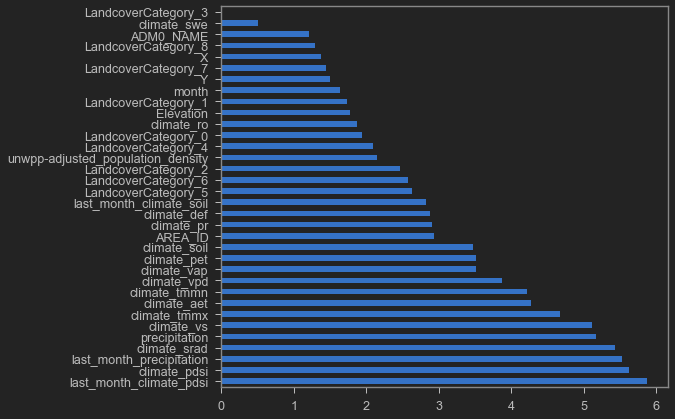

In [51]:
# Getting feature importance
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [ ]:
for fea in train.columns[1:]:
    print('The feature',fea,'has nans =',test[fea].isna().any())
    imputed = np.where(test[fea].isna().to_numpy(), test.groupby(['ADM0_NAME','AREA_ID','year','month'])[fea].mean().to_numpy(), test[fea].to_numpy()).copy()
    test.drop(fea,axis=1,inplace=True)
    test[fea] = imputed
    print('The feature',fea,'has nans =',test[fea].isna().any(),'\n============================\n')

In [ ]:
X = test.drop(['ID','X', 'Y','year'],axis=1)
y_pred = cat_model.predict(X)

In [ ]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['target'] = np.where(y_pred < 0 , 0.0, y_pred)

In [ ]:
submission.to_csv('sub11-0.0-cat17.csv',index=False)